In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
# import matplotlib.pyplot as plt
# from sklearn import preprocessing
# from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB 
from sklearn.neural_network import *
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Activation, Dense
from keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploration

In [3]:
%cd /content/drive/MyDrive/BagOfLies
df = pd.read_csv("Annotations.csv")
df_eeg = df[['eeg', 'truth']].dropna().reset_index()
df_eeg.head()

/content/drive/.shortcut-targets-by-id/1Jt_uYcC590I4L59nGxnprImCSYlvHi4G/BagOfLies


,index,eeg,truth
0,0,./Finalised/User_0/run_0/EEG.csv,1
1,1,./Finalised/User_0/run_1/EEG.csv,0
2,2,./Finalised/User_0/run_2/EEG.csv,0
3,3,./Finalised/User_0/run_3/EEG.csv,0
4,4,./Finalised/User_0/run_4/EEG.csv,0


In [4]:
# lengths = []
# for i, eeg in df_eeg.iterrows():
#   lengths.append(pd.read_csv(eeg[1]).iloc[:,1:-1].shape[0])
# fig, axs = plt.subplots(tight_layout=True)
# axs.set_title('EEG Sample Histogram')
# axs.set_xlabel('Samples per recording')
# axs.set_ylabel('Recordings per bin')
# axs.hist(lengths, bins=100)


In [5]:
df_sample = pd.read_csv(df_eeg.iloc[2,:][1]).iloc[:,1:-1]
df_sample.head()

,F3 Value,F3 Quality,FC5 Value,5C5 Quality,F7 Value,F7 Quality,T7 Value,T7 Quality,P7 Value,P7 Quality,...,F8 Value,F8 Quality,AF4 Value,AF4 Quality,FC6 Value,FC6 Quality,F4 Value,F4 Quality,X Value,Y Value
0,-121,0,-127,0,-125,0,-64,0,-99,0,...,-100,4728,-112,0,-138,0,-83,0,21,24
1,-132,0,-124,0,-116,0,-154,0,-118,0,...,-125,4728,-112,0,-145,0,-73,0,22,24
2,-126,0,-122,0,-120,0,-149,0,-118,0,...,-110,4728,-105,0,-164,0,-79,0,22,24
3,-125,2064,-123,0,-123,0,-150,0,-128,0,...,-113,4728,-104,0,-134,0,-81,0,22,24
4,-127,2064,-126,24,-121,0,-151,0,-122,0,...,-118,4728,-117,0,-63,0,-84,0,22,24


In [6]:
df_filtered = df_sample.loc[:, df_sample.columns.str.contains('Value')]
df_filtered = df_filtered.iloc[:,:-2]
df_filtered.head()

,F3 Value,FC5 Value,F7 Value,T7 Value,P7 Value,O1 Value,O2 Value,P8 Value,T8 Value,F8 Value,AF4 Value,FC6 Value,F4 Value
0,-121,-127,-125,-64,-99,-117,-148,-120,-101,-100,-112,-138,-83
1,-132,-124,-116,-154,-118,-123,-124,-139,-101,-125,-112,-145,-73
2,-126,-122,-120,-149,-118,-119,-82,-131,-98,-110,-105,-164,-79
3,-125,-123,-123,-150,-128,-122,-119,-118,-101,-113,-104,-134,-81
4,-127,-126,-121,-151,-122,-121,-169,-125,-100,-118,-117,-63,-84


In [7]:
# EEG Signal from channel F3 with noise
f3_channel_eeg = df_filtered.iloc[:,1:2]


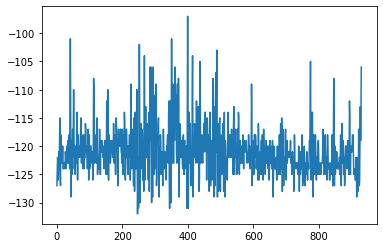

In [18]:
plt.plot(f3_channel_eeg)

In [8]:
# Filter
filter = signal.firwin(600, [0.01, 0.06], pass_zero=False)


In [9]:
# Normalized values
data_norm_to_0_1 = [number/scipy.linalg.norm(f3_channel_eeg.squeeze()) for number in f3_channel_eeg.squeeze()]
filtered_and_normalized = signal.convolve(data_norm_to_0_1, filter, mode="same")


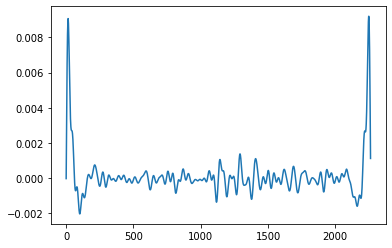

In [19]:
plt.plot(filtered_and_normalized)

# Preprocessing

In [10]:
df_eeg.head()

,index,eeg,truth
0,0,./Finalised/User_0/run_0/EEG.csv,1
1,1,./Finalised/User_0/run_1/EEG.csv,0
2,2,./Finalised/User_0/run_2/EEG.csv,0
3,3,./Finalised/User_0/run_3/EEG.csv,0
4,4,./Finalised/User_0/run_4/EEG.csv,0


In [11]:
length_of_trial = []
data = []
label = []
for i, eeg in df_eeg.iterrows():
  if i % 20 == 0:
    print("Processed trials:", i)
  df_trial = pd.read_csv(eeg[1]).iloc[:,1:-1]
  df_trial = df_trial.apply(lambda x: pd.to_numeric(x, errors = 'coerce')).dropna()
  df_trial = df_trial.loc[:, df_trial.columns.str.contains('Value')]
  if i >= 1:
    length_of_trial.append((length_of_trial[i-1][1]+1, length_of_trial[i-1][1] + df_trial.shape[0]))
  else:
    length_of_trial.append((0, df_trial.shape[0]))
  for col in df_trial:
    data_norm_to_0_1 = [number/scipy.linalg.norm(df_trial[col].squeeze()) for number in df_trial[col].squeeze()]
    filtered_and_normalized = signal.convolve(data_norm_to_0_1, filter, mode="same")
    df_trial[col] = filtered_and_normalized
    df_trial["label"] = eeg[2]
  for j, row in df_trial.iterrows():
    data.append(row.values[:-1])
    label.append(row.values[-1])

print(data.__len__())
print(label.__len__())
data = np.asarray(data)
label = np.asarray(label)

Processed trials: 0
Processed trials: 20
Processed trials: 40
Processed trials: 60
Processed trials: 80
Processed trials: 100
Processed trials: 120
Processed trials: 140
Processed trials: 160
Processed trials: 180
Processed trials: 200
271427
271427


In [12]:
print(data.shape)
print(label.shape)

(271427, 15)
(271427,)


# Gaussian Naive Bayes

In [13]:
from tensorflow.python.ops.init_ops import ConvolutionDeltaOrthogonal
accuracies = []
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(length_of_trial, length_of_trial):
  X_train, y_train = [], []
  for index in train_index:
    start, end = length_of_trial[index]
    for row in data[start:end]:
      X_train.append(row)
    for row in label[start:end]:
      y_train.append(row)
    learned_model = GaussianNB().fit(X_train, y_train)


  score = 0
  for index in test_index:
    X_test, y_test = [], []
    start, end = length_of_trial[index]
    for row in data[start:end]:
      X_test.append(row)
    for row in label[start:end]:
      y_test.append(row)
    prediction = learned_model.predict_proba(np.asarray(X_test))
    mysum = 0
    for p in prediction:
      mysum += p[1]
    if mysum/X_test.__len__() >= 0.5:
    #if sum(prediction == 1) >= X_test.__len__() / 2:
      pred = 1
    else:
      pred = 0
    if y_test[0] == pred:
      score += 1
  accuracies.append(score/test_index.__len__())
  print(score/test_index.__len__())
print("Model {} with avg test accuracy: {}".format(GaussianNB(), sum(accuracies)/accuracies.__len__()))  

0.5609756097560976
0.6
0.475
0.575
0.625
Model GaussianNB() with avg test accuracy: 0.5671951219512195


# Bernoulli naive bayes

In [14]:
from tensorflow.python.ops.init_ops import ConvolutionDeltaOrthogonal
accuracies = []
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(length_of_trial, length_of_trial):
  X_train, y_train = [], []
  for index in train_index:
    start, end = length_of_trial[index]
    for row in data[start:end]:
      X_train.append(row)
    for row in label[start:end]:
      y_train.append(row)
    learned_model = BernoulliNB().fit(X_train, y_train)


  score = 0
  for index in test_index:
    X_test, y_test = [], []
    start, end = length_of_trial[index]
    for row in data[start:end]:
      X_test.append(row)
    for row in label[start:end]:
      y_test.append(row)
    prediction = learned_model.predict_proba(np.asarray(X_test))
    mysum = 0
    for p in prediction:
      mysum += p[1]
    if mysum/X_test.__len__() >= 0.5:
    #if sum(prediction == 1) >= X_test.__len__() / 2:
      pred = 1
    else:
      pred = 0
    if y_test[0] == pred:
      score += 1
  accuracies.append(score/test_index.__len__())
  print(score/test_index.__len__())
print("Model {} with avg test accuracy: {}".format(BernoulliNB(), sum(accuracies)/accuracies.__len__()))  

0.5365853658536586
0.575
0.675
0.55
0.375
Model BernoulliNB() with avg test accuracy: 0.5423170731707317


In [15]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
X_test_array = np.array(X_test)
y_test_array = np.array(y_test)

In [16]:
max([len(i) for i in X_train])

15

In [17]:
y_train_array.shape

(223410,)